# TP2 - Análise de Hiper-parâmetros no PSO
### EEE882 - Computação Evolucionária

#### Matheus Bitarães de Novaes

In [1]:
# imports para o problema
import math
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Introdução

Neste notebook iremos explorar a função PSO para otimizar duas funções, uma unimodal e outra multimodal.


## Tarefa 1:
Esta tarefa consiste em escolher e implementar duas funções de teste apresentadas na tabela abaixo, sendo uma delas unimodal e a outra multimodal.

https://www.ntu.edu.sg/home/epnsugan/index_files/cec2013/Definitions%20of%20%20CEC%2013%20benchmark%20suite%200117.pdf 

funções escolhidas:
- unimodal: **Sphere Function**
- multimodal: **Rastrigin’s Function**

### Sphere Function: Implementação 

<IPython.core.display.Javascript object>


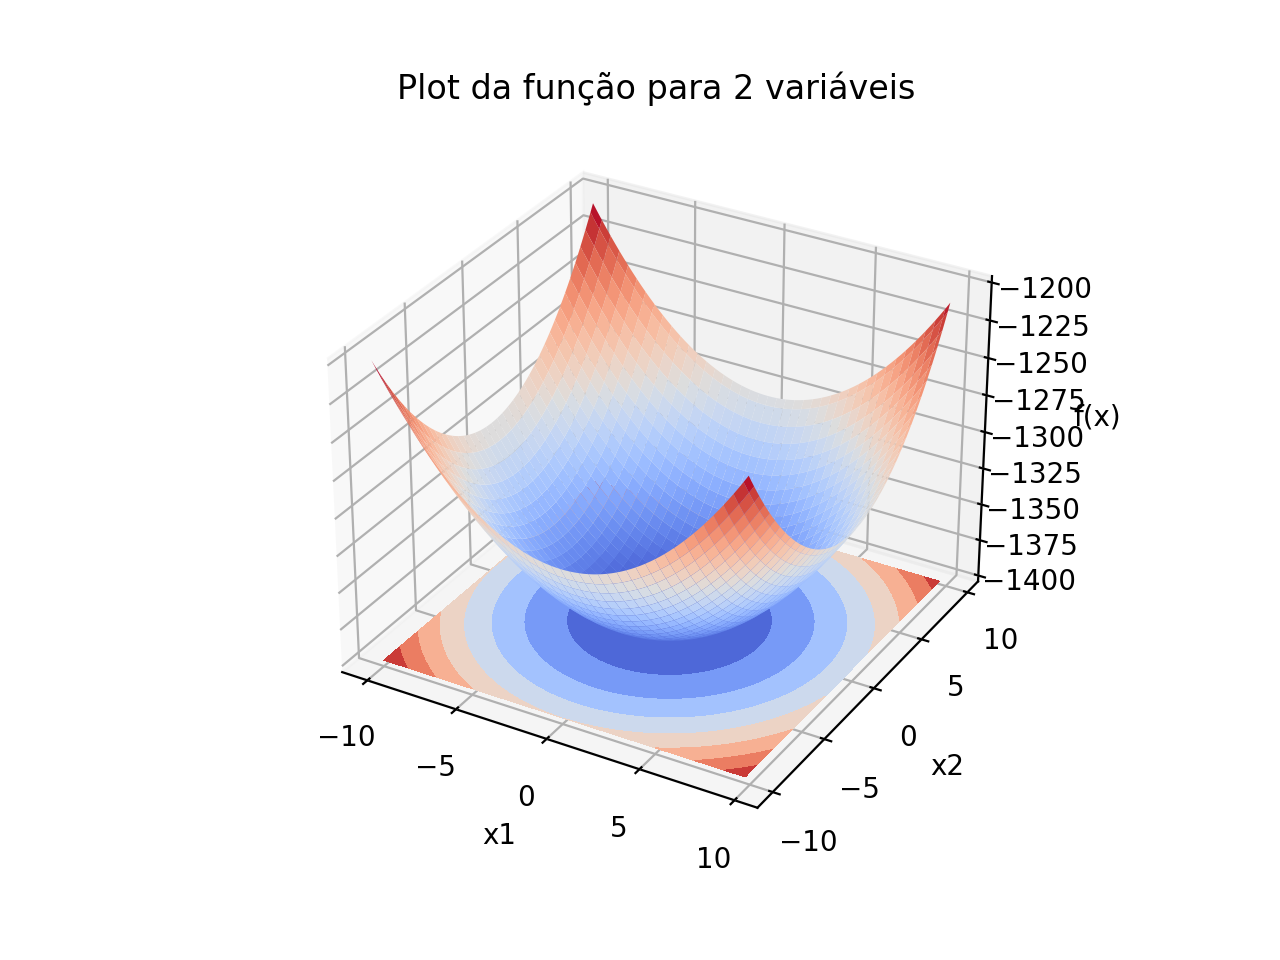

Text(0.5, 0, 'f(x)')

In [14]:
# implementaçao em python adaptada do codigo em matlab disponivel em https://www.sfu.ca/~ssurjano/Code/spherefm.html
def spheref (x): #input x = [x1, x2, ...]
    y = 0
    f = -1400 # valor da tabela disponivel em https://www.ntu.edu.sg/home/epnsugan/index_files/cec2013/Definitions%20of%20%20CEC%2013%20benchmark%20suite%200117.pdf
    for i in range(0,len(x)):
        y = y + pow(x[i], 2)
    return y + f

# plot da função para 2 variáveis
%matplotlib notebook

# variáveis
x1 = np.arange(-10, 10, 0.25)
x2 = np.arange(-10, 10, 0.25)
y = np.zeros((len(x1), len(x2)))
for i in range(0, len(x1)):
    for j in range (0, len(x2)):
        y[i][j] = spheref([x1[i], x2[j]])
        

# grid
x1, x2 = np.meshgrid(x1, x2)
fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot
surf = ax.plot_surface(x1, x2, y, cmap=cm.coolwarm,
                       linewidth=1, antialiased=True)

cset = ax.contourf(x1, x2, y, zdir='z', offset=-1400, cmap=cm.coolwarm)

ax.set_title('Plot da função para 2 variáveis')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x)')

### Rastrigin’s Function: Implementação

<IPython.core.display.Javascript object>


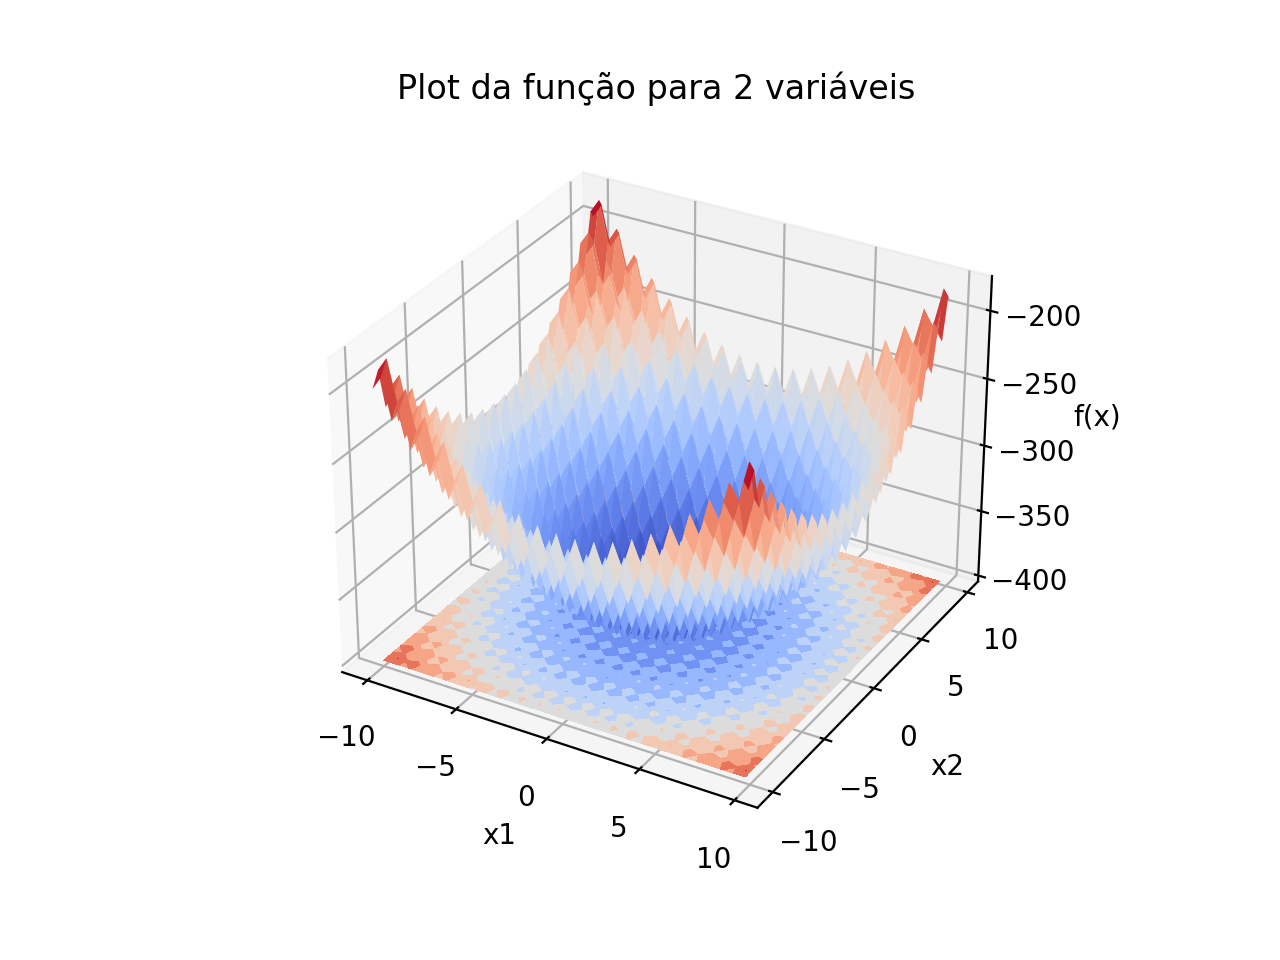

Text(0.5, 0, 'f(x)')

In [15]:
# implementaçao em python adaptada da funçao disponivel em https://www.ntu.edu.sg/home/epnsugan/index_files/cec2013/Definitions%20of%20%20CEC%2013%20benchmark%20suite%200117.pdf
def rastrf (x):
    y = 0
    f = -400 # valor da tabela disponivel em https://www.ntu.edu.sg/home/epnsugan/index_files/cec2013/Definitions%20of%20%20CEC%2013%20benchmark%20suite%200117.pdf
    for i in range(0, len(x)):
        y = y + pow(x[i], 2) - 10 * np.cos(2 * np.pi * x[i]) + 10
    return y + f

# plot da função para 2 variáveis
%matplotlib notebook

# variáveis
x1 = np.arange(-10, 10, 0.25)
x2 = np.arange(-10, 10, 0.25)
y = np.zeros((len(x1), len(x2)))
for i in range(0, len(x1)):
    for j in range (0, len(x2)):
        y[i][j] = rastrf([x1[i], x2[j]])
        
# grid
x1, x2 = np.meshgrid(x1, x2)
fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(x1, x2, y, cmap=cm.coolwarm,
                       linewidth=1, antialiased=True)

cset = ax.contourf(x1, x2, y, zdir='z', offset=-400, cmap=cm.coolwarm)

ax.set_title('Plot da função para 2 variáveis')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x)')

## Tarefa 2

Devemos desenvolver um PSO  e executá-lo para cada uma das duas funções de teste escolhidas na Tarefa 1 com as configurações abaixo:

[<img src="tabela1.png" width="500px"/>](attachment:tabela1.png)

Primeiramente vamos implementar a função genérica do PSO

In [4]:
# definição da função que executará o algoritmo PSO
def pso(f, p, d, pso_type="gbest", bound=[-100, 100], chi=1, w=1, c1=1, c2=1, comput_budget=100000):
    # f: função objetivo
    # p: numero de particulas
    # d: dimensao do problema
    # bound: [min, max] -> limites do espaço de busca
    # chi: parametro de constrição
    # w: peso de inércia
    # c1: coeficiente de aceleração da parecela cognitiva do calculo de velocidade
    # c2: coeficiente de aceleração da parcela social do calculo de velocidade
    # comput_budget: numero maximo de avaliações da função objetivo

    # inicialização de variáveis
    num_eval = 0
    global_best_position_x = []
    global_best_position_fx = []
    personal_best_x = np.zeros((p, d))
    personal_best_fx = np.inf * np.ones(p)
    group_best_x = np.zeros((p, d))
    fx = np.inf * np.ones(p)
    t = 0

    # Inicializacão das particulas. Inicialização uniforme no espaço de busca
    x = np.random.uniform(bound[0], bound[1], [p, d])

    # inicialização das velocidades como nulas
    v = np.zeros((p, d))

    # inicio do loop
    while num_eval <= comput_budget:

        # loop em todas as particulas
        for i in range(0, p):

            # avalia função
            fx[i] = f(x[i])
            num_eval = num_eval + 1

            # seta melhor posicão da iteração
            if fx[i] < personal_best_fx[i]:
                personal_best_x[i] = x[i]
                personal_best_fx[i] = fx[i]

        # após primeiro loop para ter todas as avaliações de função,
        # novo loop para pegar as melhores particulas na vizinhança
        if pso_type == 'lbest': # só é necessario para o lbest
            for i in range(0, p):

                # vizinhança em anel
                if i == 0:
                    N = [p - 1, i, i + 1]
                elif i == p - 1:
                    N = [i - 1, i, 0]
                else:
                    N = [i - 1, i, i + 1]

                # atualiza melhor posição da vizinhança (lbest)
                group_best_fx = min(fx[N])
                group_best_x[i] = np.array(x[fx == group_best_fx][0])


        # Atualiza valores globais de minimo (gbest)
        global_best_fx = min(personal_best_fx)
        global_best_x = np.array(personal_best_x[personal_best_fx == global_best_fx][0])
        global_best_position_fx.append(global_best_fx)
        global_best_position_x.append(global_best_x)

        # atualização das velocidades e das particulas
        for i in range(0, p):
            if pso_type == "lbest":
                gbp = group_best_x[i]
            else:
                gbp = global_best_position_x[t]
            lbp = personal_best_x[i]
            r1 = np.random.random()
            r2 = np.random.random()
            v_cognitive = c1 * r1 * (lbp - x[i])
            v_social = c2 * r2 * (gbp - x[i])
            v[i] = chi * (w * v[i] + v_cognitive + v_social)
            x[i] = x[i] + v[i]

            # aplica limite superior e inferior
            x[i][x[i] > bound[1]] = bound[1]
            x[i][x[i] < bound[0]] = bound[0]

        t = t + 1  # atualiza tempo
    
    return global_best_position_fx, global_best_position_x, t

Vamos testar a convergência do PSO para 2 variáveis, usando o **global best PSO (gbest)** e o **local best PSO(lbest)**

<IPython.core.display.Javascript object>


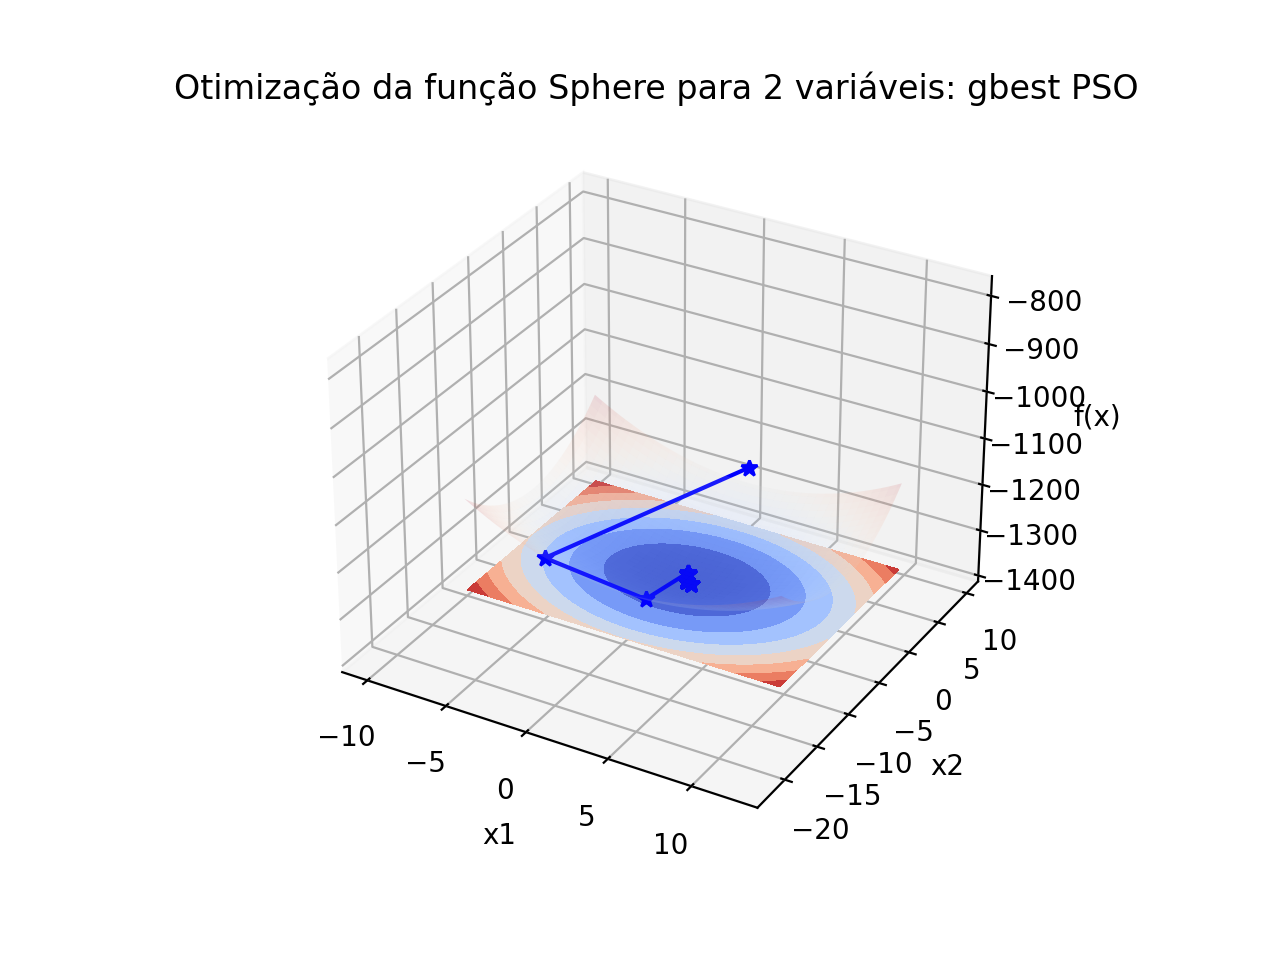

<IPython.core.display.Javascript object>


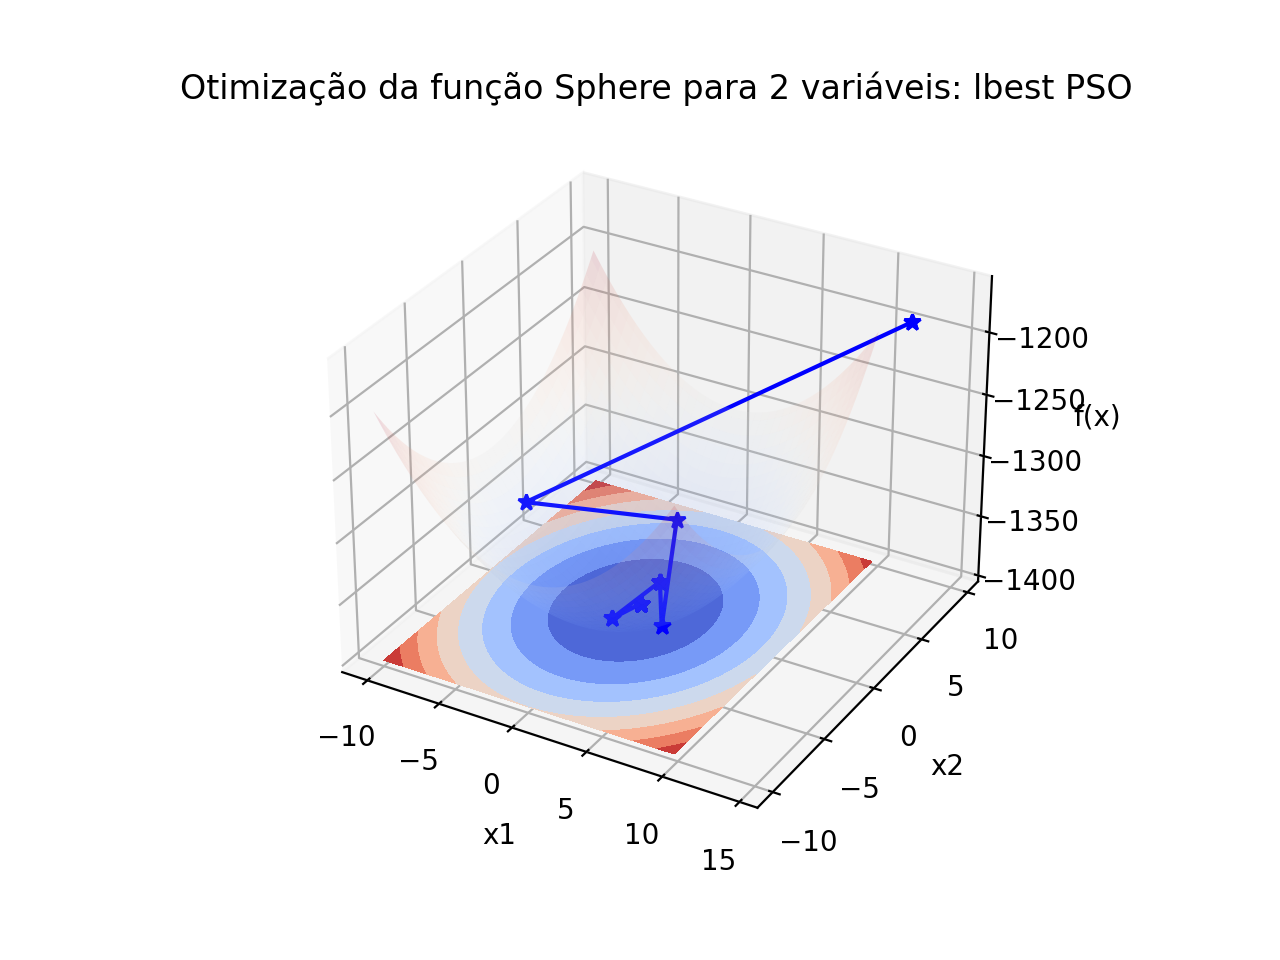

<IPython.core.display.Javascript object>


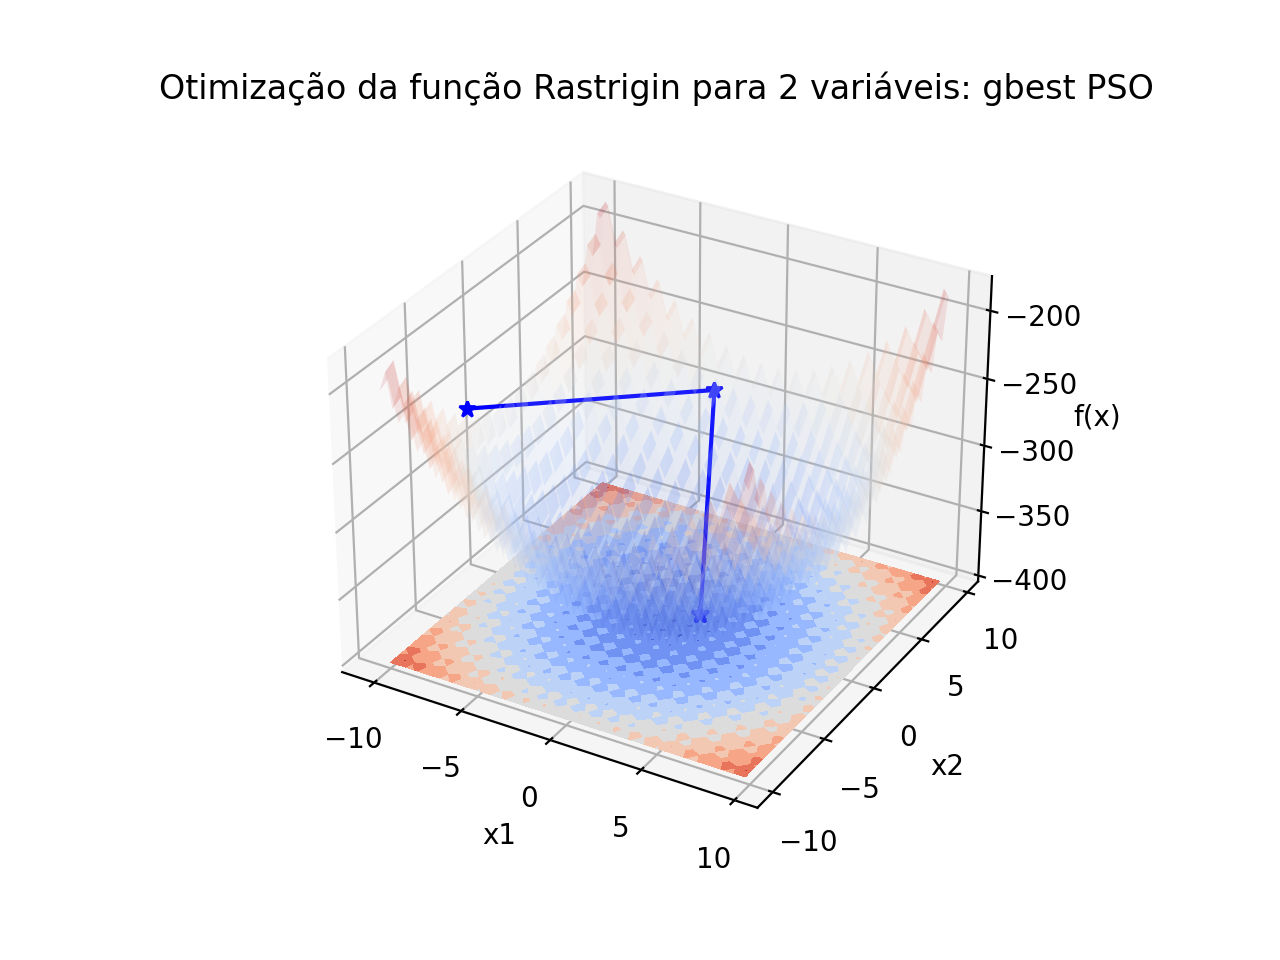

<IPython.core.display.Javascript object>


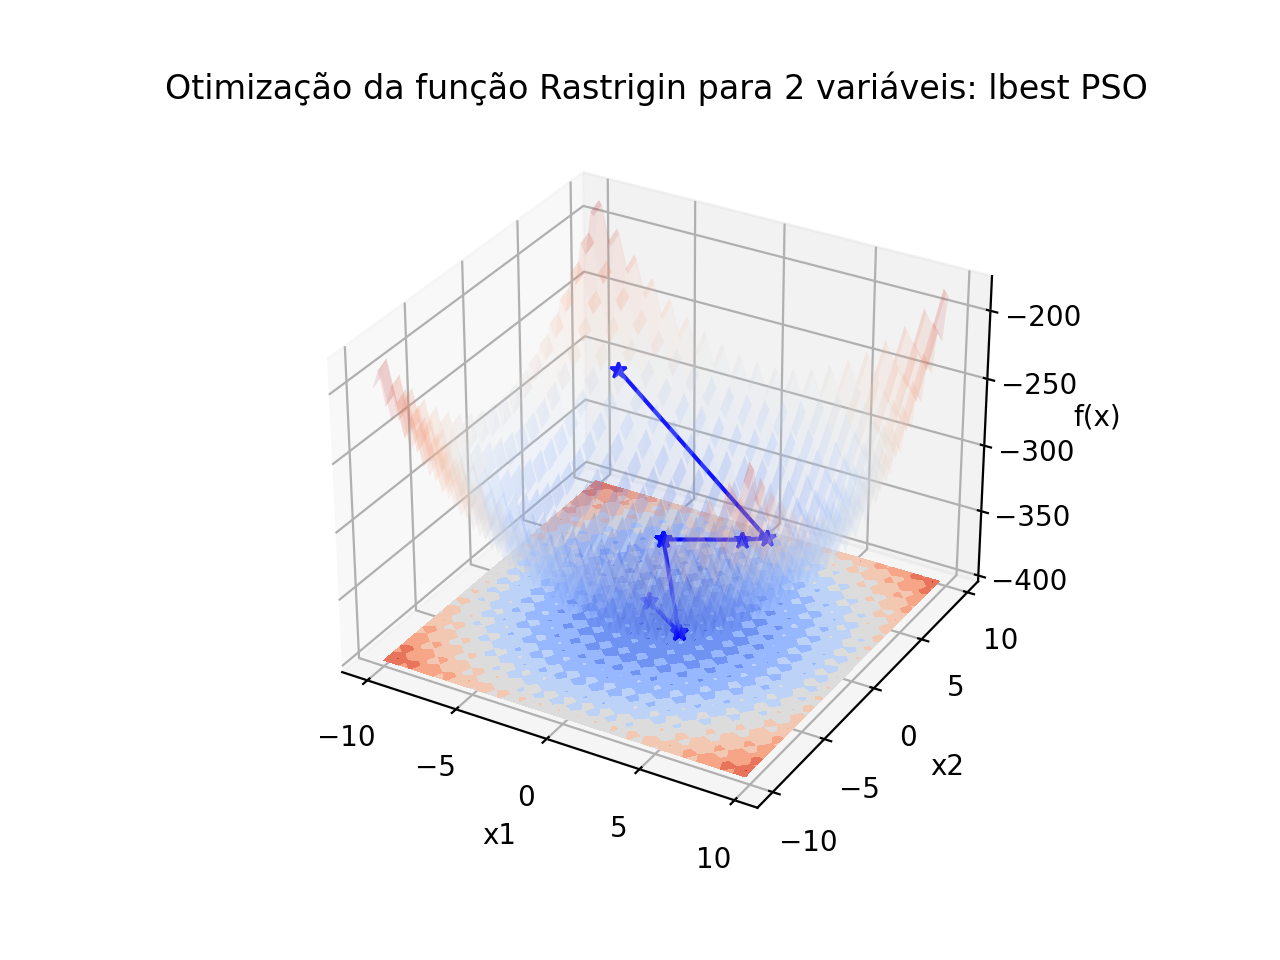

In [5]:
# definição de função de plotagem
def pso_surface_plot(s, x, f, title, offset):
    xa = []
    xb = []
    for i in range(len(x)):
        xa.append(x[i][0])
        xb.append(x[i][1])

    # variáveis
    x1 = np.arange(-10, 10, 0.25)
    x2 = np.arange(-10, 10, 0.25)
    y = np.zeros((len(x1), len(x2)))
    for i in range(0, len(x1)):
        for j in range (0, len(x2)):
            y[i][j] = f([x1[i], x2[j]])

    # grid
    x1, x2 = np.meshgrid(x1, x2)
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    surf = ax.plot_surface(x1, x2, y, cmap=cm.coolwarm,
                           linewidth=1, antialiased=True, alpha=.125)

    cset = ax.contourf(x1, x2, y, zdir='z', offset=offset, cmap=cm.coolwarm)
    ax.plot3D(xa, xb, s[:], c='b', marker='*', zorder=10)

    ax.set_title(title)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('f(x)')

# plotagem
%matplotlib notebook

# Função Sphere
bound = [-50, 50]
x, s, it = pso(spheref, 10, 2, "gbest", bound, 1, 1, 1, 1, 1000)
pso_surface_plot(x, s, spheref, 'Otimização da função Sphere para 2 variáveis: gbest PSO', -1400)

x, s, it = pso(spheref, 10, 2, "lbest", bound, 1, 1, 1, 1, 1000)
pso_surface_plot(x, s, spheref, 'Otimização da função Sphere para 2 variáveis: lbest PSO', -1400)

# Função Rastrigin
x, s, it = pso(rastrf, 10, 2, "gbest", bound, 1, 1, 1, 1, 1000)
pso_surface_plot(x, s, rastrf, 'Otimização da função Rastrigin para 2 variáveis: gbest PSO', -400)

x, s, it = pso(rastrf, 10, 2, "lbest", bound, 1, 1, 1, 1, 1000)
pso_surface_plot(x, s, rastrf, 'Otimização da função Rastrigin para 2 variáveis: lbest PSO', -400)


## Tarefa 3

Agora iremos definir o set de hiper-parâmetros do problema e analisar as execuções para a função unimodal e para a função multimodal

### Execução

In [6]:
# Hiper-parâmetros definidos no enunciado do problema
D = 10 # dimensões
num_exec = 31 # numero de execuções de cada função
comput_budget = 100000 # recurso computacional
bound = [-100, 100] # limite inferior e superior das variaveis do problema

Fora os parâmetros fixados no enunciado do problema, temos outros 3 parâmetros que podem ser configurados. O tamanho da população e as duas constantes do pso, c1 e c2. Foi decidido por dar o mesmo peso para as constantes social e cognitiva. Ambas ficarão com valor 1.

 * **Sphere:** Para a definição da população foi considerado o seguinte: Como o problema é unimodal, parece ser mais interessante ter um número maior de iterações em detrimento de uma população maior. Então inicialmente estipulado que 1000 iterações seria um número rasoável para a evolução das particulas. Como temos um orçamento de 100.000 avaliações de função e cada iteração avalia a função uma vez para cada partícula, podemos ter portanto uma população de 100 particulas.
 
* **Rastrigin:** Por ser uma função com vários mínimos, os parametros serão modificados de forma a privilegiar uma maior exploração da região factível, com uma população maior para poder gerar soluções mais diversas e portanto privilegiar a conversão ao ótimo global. Portanto, para esta função, iremos com uma população de 150 individuos e, portanto, menos iterações. 

In [7]:
# Definição de uma função para multiplas execuções
def multiple_PSO_execution(num_exec, spheref, P, D, PSO_type, bound, chi, w, c1, c2, comput_budget):
    s = []
    print("executing PSO type ", PSO_type, ", chi: ", chi,", w: ", w, "...")
    for i in range(0, num_exec):
        print(i + 1, " times")
        fx, x, it = pso(spheref, P, D, PSO_type, bound, chi, w, c1, c2, comput_budget)
        s.append(fx[-1]) # armazena apenas ultimo resultado, que é o ponto ótimo encontrado
    return s 

In [8]:
# Definição de função de plotagem
def pso_displot(s1, s2, title):
    kwargs = dict(hist_kws={'alpha':.5}, kde_kws={'linewidth':2})

    plt.figure(figsize=(10,7), dpi= 80)
    label1 = "gbest PSO. mean: " + str(round(np.mean(s1), 2)) + " std: " + str(round(np.std(s1), 2))
    label2 = "lbest PSO. mean: " + str(round(np.mean(s2), 2)) + " std: " + str(round(np.std(s2), 2))
    sns.distplot(s1, color="dodgerblue", label=label1, **kwargs)
    sns.distplot(s2, color="deeppink", label=label2, **kwargs)
    plt.title(title)
    plt.legend();

Em algumas das execuções utilizaremos valores de w e chi que serão diferentes de 1. Para a função **Sphere**, utilizaremos os seguintes valores:

 - **w = 0.4**. Valores menores, mais proximos de zero, favorecem mais as condições sociais e cognitivas para a movimentação da partícula. Por ser uma função unimodal, faz sentido colocar um peso menor na inércia(w).
 
 - **chi = 0.5**. Valores baixos de chi e w favorecem a exploração de um único objetivo, pois tendem e diminuir o passo das velocidades.

In [9]:
## SPHERE

# Hiper-parâmetros variáveis
P = 100 # tamanho da população
c1 = 1 # constantes do PSO (geralmente entre 1 e 2)
c2 = 1 # constantes do PSO (geralmente entre 1 e 2)

# chi = 1, w = 1
chi = 1
w = 1
s_gbestA1 = multiple_PSO_execution(num_exec, spheref, P, D, "gbest", bound, chi, w, c1, c2, comput_budget)
s_lbestA1 = multiple_PSO_execution(num_exec, spheref, P, D, "lbest", bound, chi, w, c1, c2, comput_budget)

# chi = 1, 0 < w < 1
chi = 1
w = .4
s_gbestB1 = multiple_PSO_execution(num_exec, spheref, P, D, "gbest", bound, chi, w, c1, c2, comput_budget)
s_lbestB1 = multiple_PSO_execution(num_exec, spheref, P, D, "lbest", bound, chi, w, c1, c2, comput_budget)

# 0 < chi < 1, w = 1
chi = .5
w = 1
s_gbestC1 = multiple_PSO_execution(num_exec, spheref, P, D, "gbest", bound, chi, w, c1, c2, comput_budget)
s_lbestC1 = multiple_PSO_execution(num_exec, spheref, P, D, "lbest", bound, chi, w, c1, c2, comput_budget)

# 0 < chi < 1, 0 < w < 1
chi = .5
w = .4
s_gbestD1 = multiple_PSO_execution(num_exec, spheref, P, D, "gbest", bound, chi, w, c1, c2, comput_budget)
s_lbestD1 = multiple_PSO_execution(num_exec, spheref, P, D, "lbest", bound, chi, w, c1, c2, comput_budget)

executing PSO type  gbest , chi:  1 , w:  1 ...
1  times
2  times
3  times
4  times
5  times
6  times
7  times
8  times
9  times
10  times
11  times
12  times
13  times
14  times
15  times
16  times
17  times
18  times
19  times
20  times
21  times
22  times
23  times
24  times
25  times
26  times
27  times
28  times
29  times
30  times
31  times
executing PSO type  lbest , chi:  1 , w:  1 ...
1  times
2  times
3  times
4  times
5  times
6  times
7  times
8  times
9  times
10  times
11  times
12  times
13  times
14  times
15  times
16  times
17  times
18  times
19  times
20  times
21  times
22  times
23  times
24  times
25  times
26  times
27  times
28  times
29  times
30  times
31  times
executing PSO type  gbest , chi:  1 , w:  0.4 ...
1  times
2  times
3  times
4  times
5  times
6  times
7  times
8  times
9  times
10  times
11  times
12  times
13  times
14  times
15  times
16  times
17  times
18  times
19  times
20  times
21  times
22  times
23  times
24  times
25  times
26  times
2

Em algumas das execuções utilizaremos valores de w e chi que serão diferentes de 1. Para a função **Rastrigin**, utilizaremos os seguintes valores:

 - **w = 0.9**. Valores maiores de w irão facilitar a inércia que pode ajudar a escapar de mínimos locais.
 
 - **chi = 0.7**. Valores maiores de chi e w evitam que o algoritmo diminua sua velocidade muito rápido ao longo das iterações, tentando evitar assim a convergencia em mínimos globais.

In [10]:
# RASTRIGIN
# Hiper-parâmetros variáveis
P = 150 # tamanho da população
c1 = 1 # constantes do PSO (entre 1 e 2)
c2 = 1 # constantes do PSO (entre 1 e 2)

# chi = 1, w = 1
chi = 1
w = 1

s_gbestA2 = multiple_PSO_execution(num_exec, rastrf, P, D, "gbest", bound, chi, w, c1, c2, comput_budget)
s_lbestA2 = multiple_PSO_execution(num_exec, rastrf, P, D, "lbest", bound, chi, w, c1, c2, comput_budget)

# chi = 1, 0 < w < 1
chi = 1
w = .9

s_gbestB2 = multiple_PSO_execution(num_exec, rastrf, P, D, "gbest", bound, chi, w, c1, c2, comput_budget)
s_lbestB2 = multiple_PSO_execution(num_exec, rastrf, P, D, "lbest", bound, chi, w, c1, c2, comput_budget)

# 0 < chi < 1, w = 1
chi = .7
w = 1

s_gbestC2 = multiple_PSO_execution(num_exec, rastrf, P, D, "gbest", bound, chi, w, c1, c2, comput_budget)
s_lbestC2 = multiple_PSO_execution(num_exec, rastrf, P, D, "lbest", bound, chi, w, c1, c2, comput_budget)

# 0 < chi < 1, 0 < w < 1
chi = .7
w = .9

s_gbestD2 = multiple_PSO_execution(num_exec, rastrf, P, D, "gbest", bound, chi, w, c1, c2, comput_budget)
s_lbestD2 = multiple_PSO_execution(num_exec, rastrf, P, D, "lbest", bound, chi, w, c1, c2, comput_budget)

executing PSO type  gbest , chi:  1 , w:  1 ...
1  times
2  times
3  times
4  times
5  times
6  times
7  times
8  times
9  times
10  times
11  times
12  times
13  times
14  times
15  times
16  times
17  times
18  times
19  times
20  times
21  times
22  times
23  times
24  times
25  times
26  times
27  times
28  times
29  times
30  times
31  times
executing PSO type  lbest , chi:  1 , w:  1 ...
1  times
2  times
3  times
4  times
5  times
6  times
7  times
8  times
9  times
10  times
11  times
12  times
13  times
14  times
15  times
16  times
17  times
18  times
19  times
20  times
21  times
22  times
23  times
24  times
25  times
26  times
27  times
28  times
29  times
30  times
31  times
executing PSO type  gbest , chi:  1 , w:  0.9 ...
1  times
2  times
3  times
4  times
5  times
6  times
7  times
8  times
9  times
10  times
11  times
12  times
13  times
14  times
15  times
16  times
17  times
18  times
19  times
20  times
21  times
22  times
23  times
24  times
25  times
26  times
2

### Analise dos resultados

#### Sphere

<IPython.core.display.Javascript object>


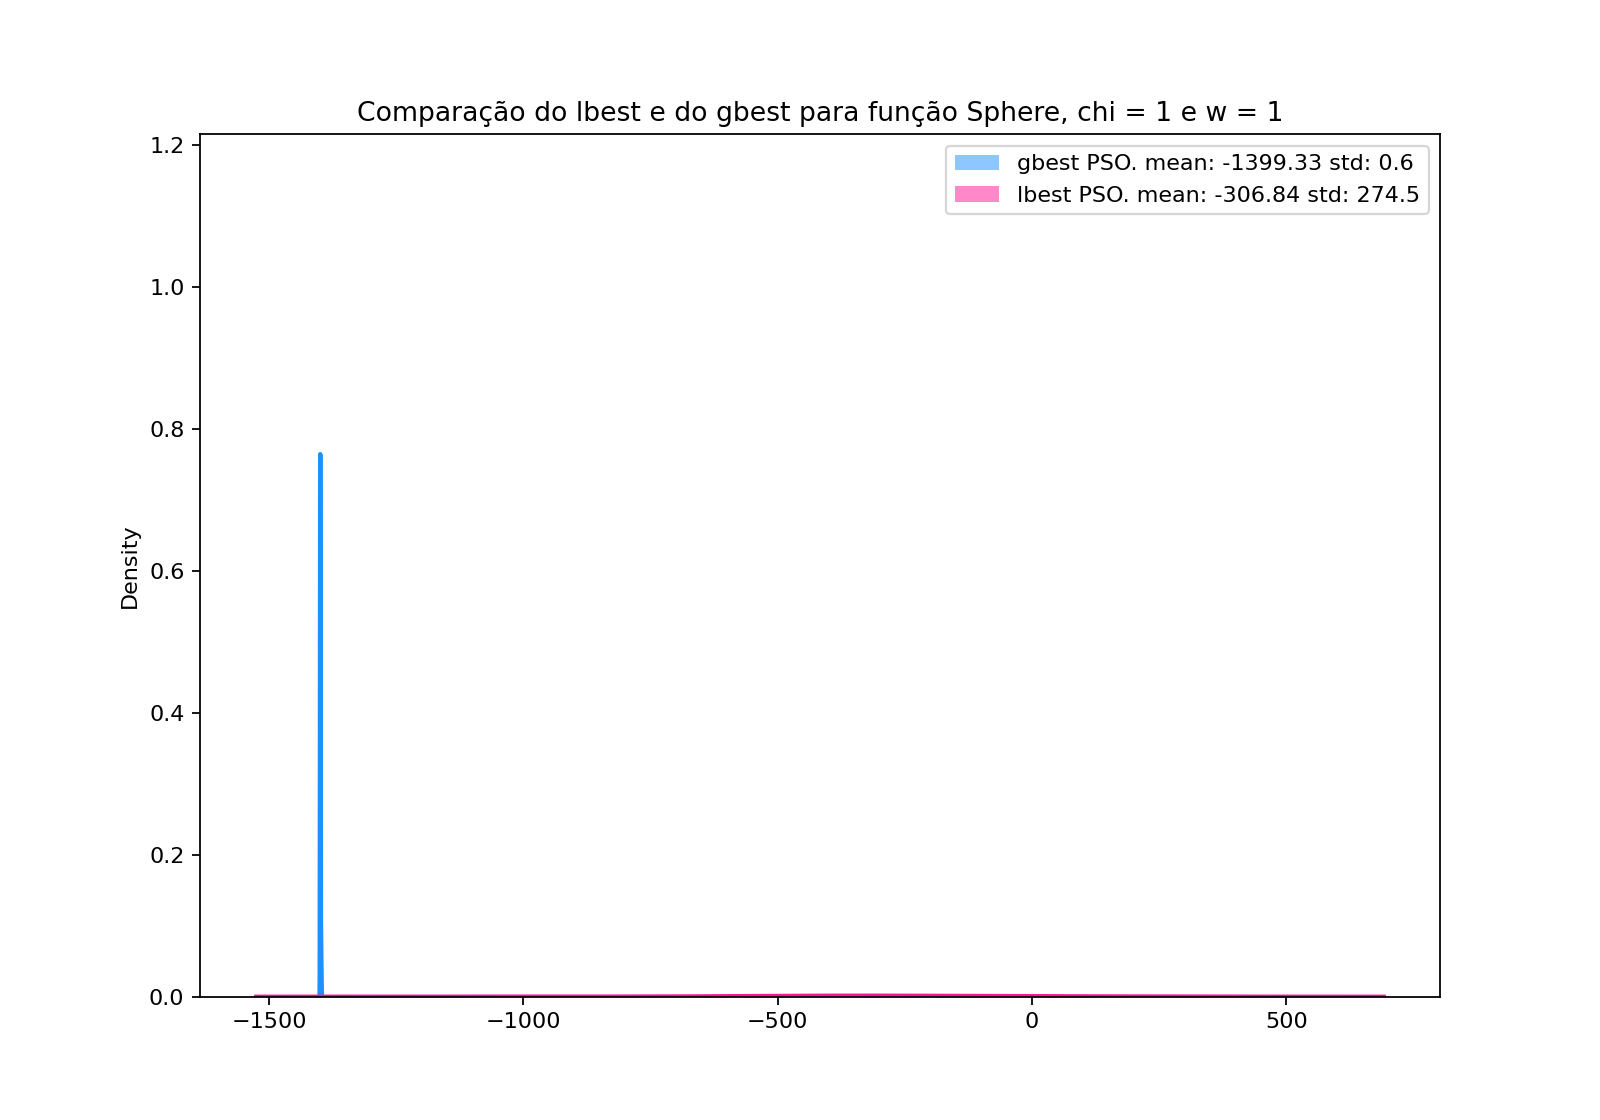

<IPython.core.display.Javascript object>


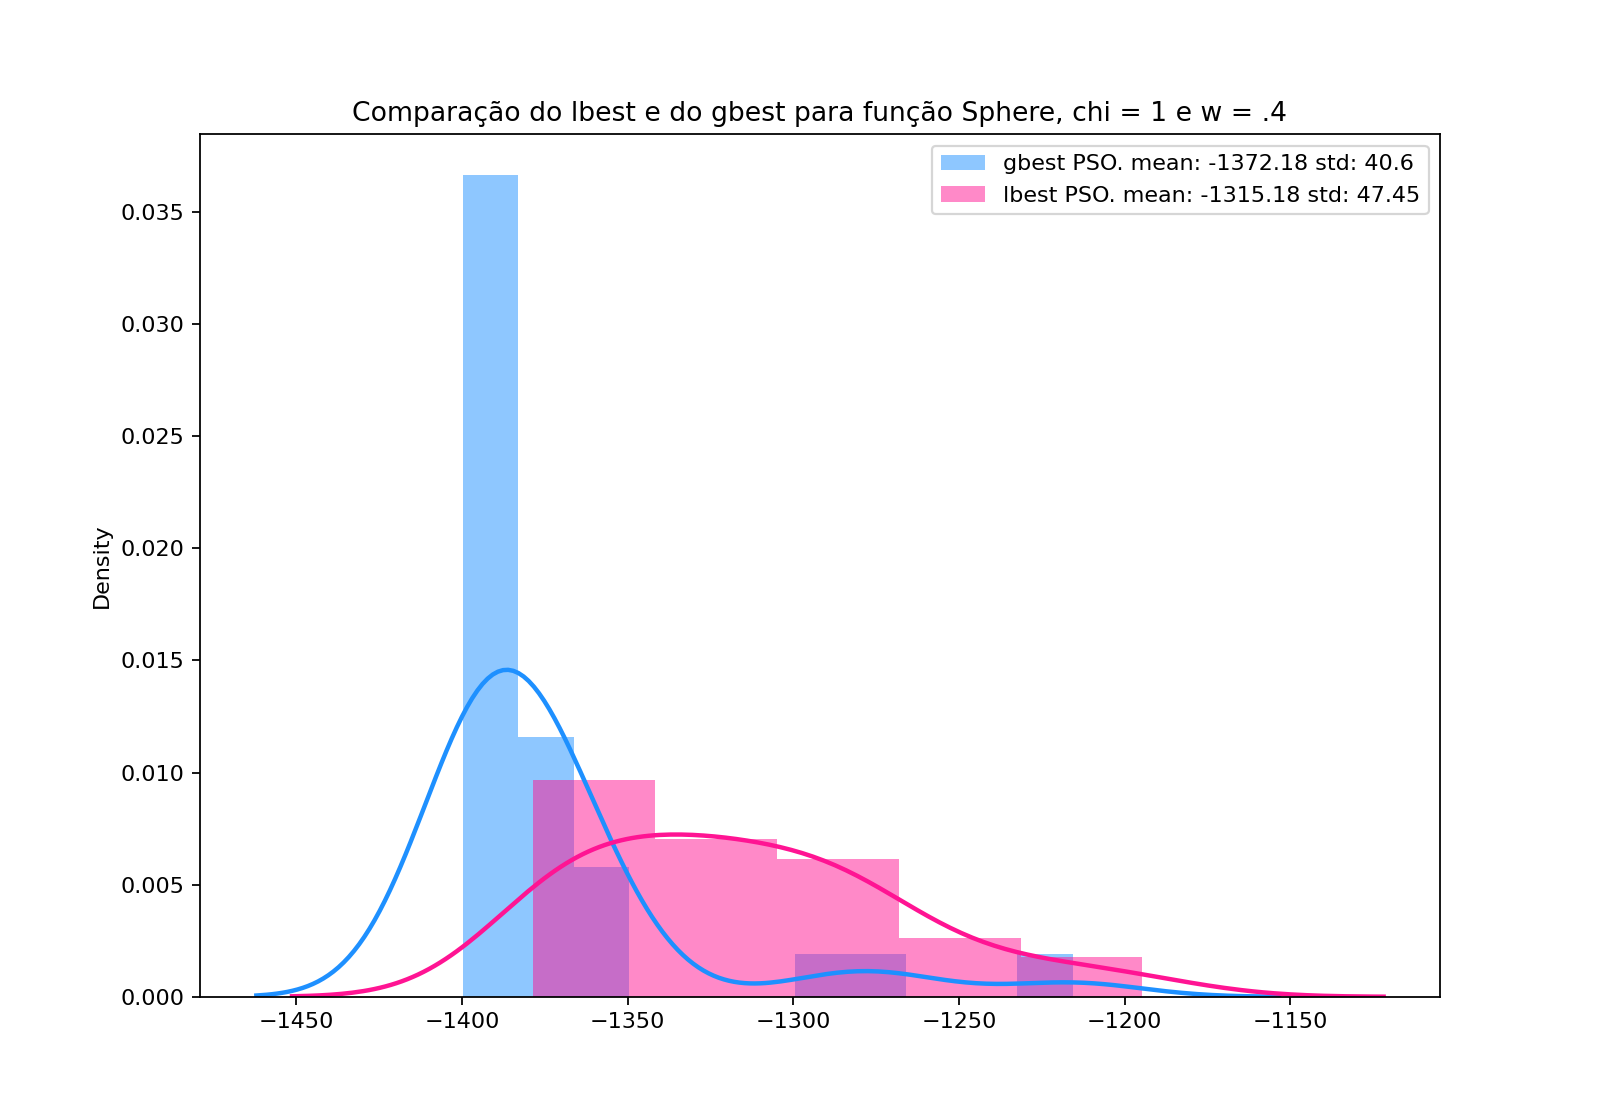

<IPython.core.display.Javascript object>


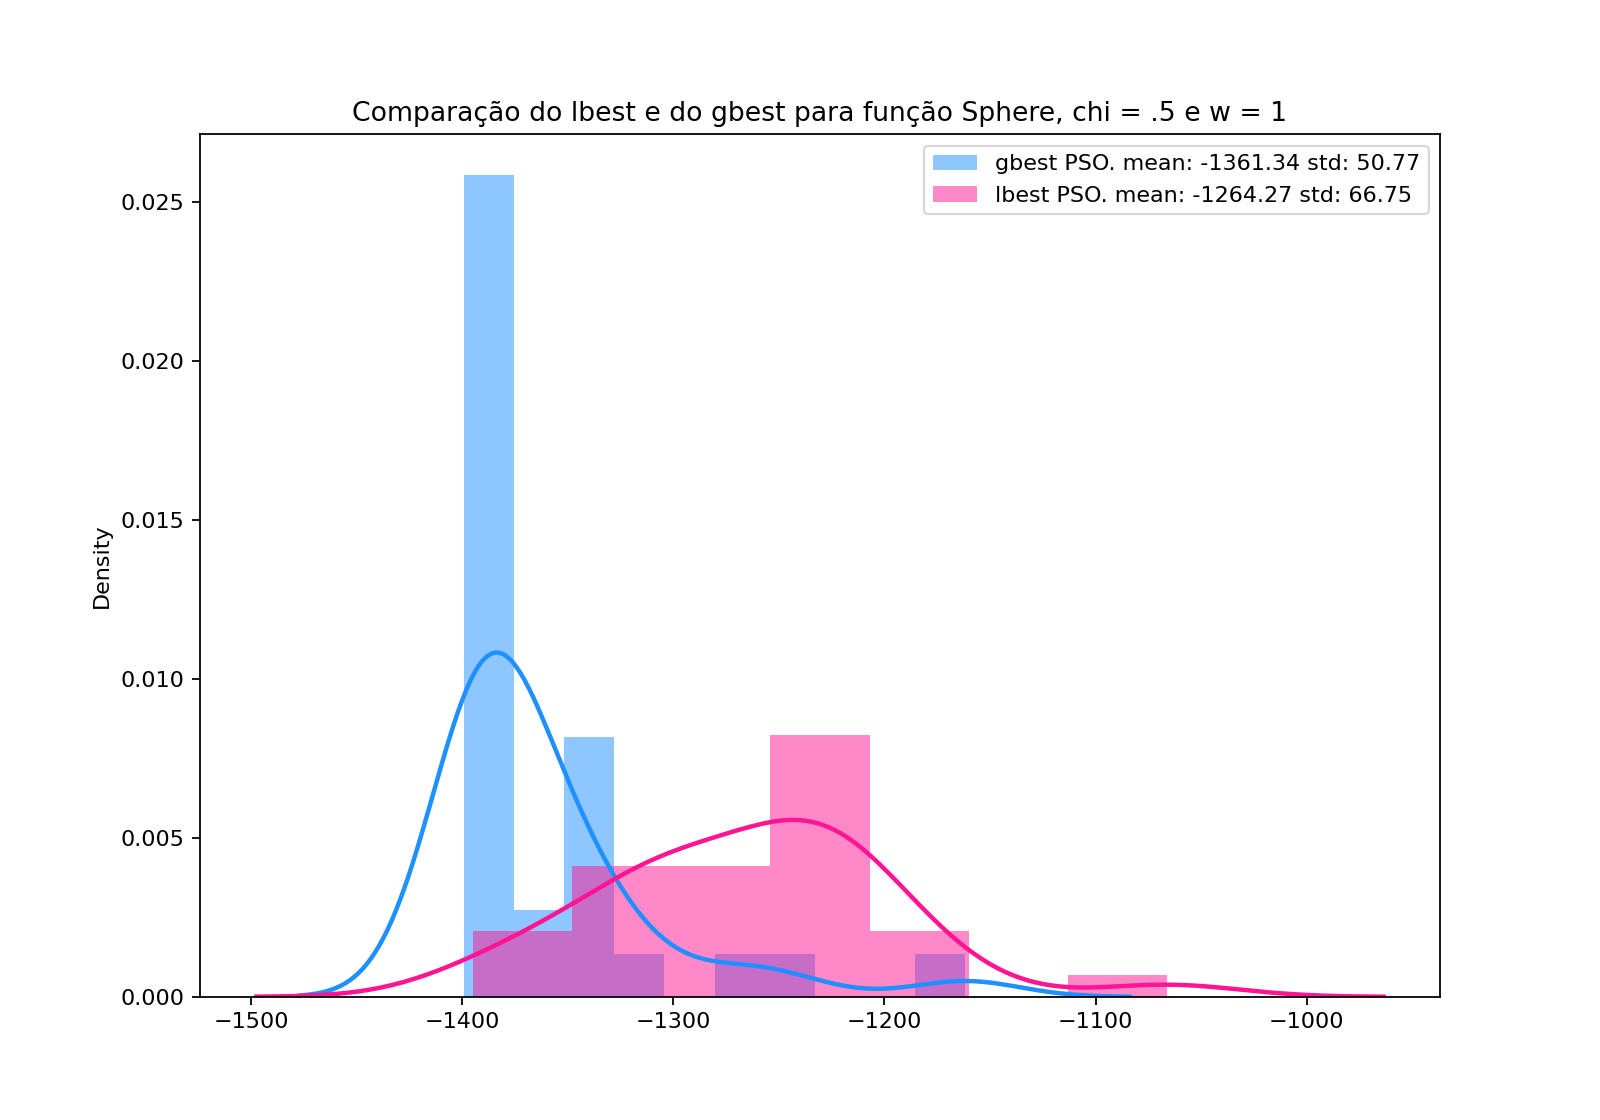

<IPython.core.display.Javascript object>


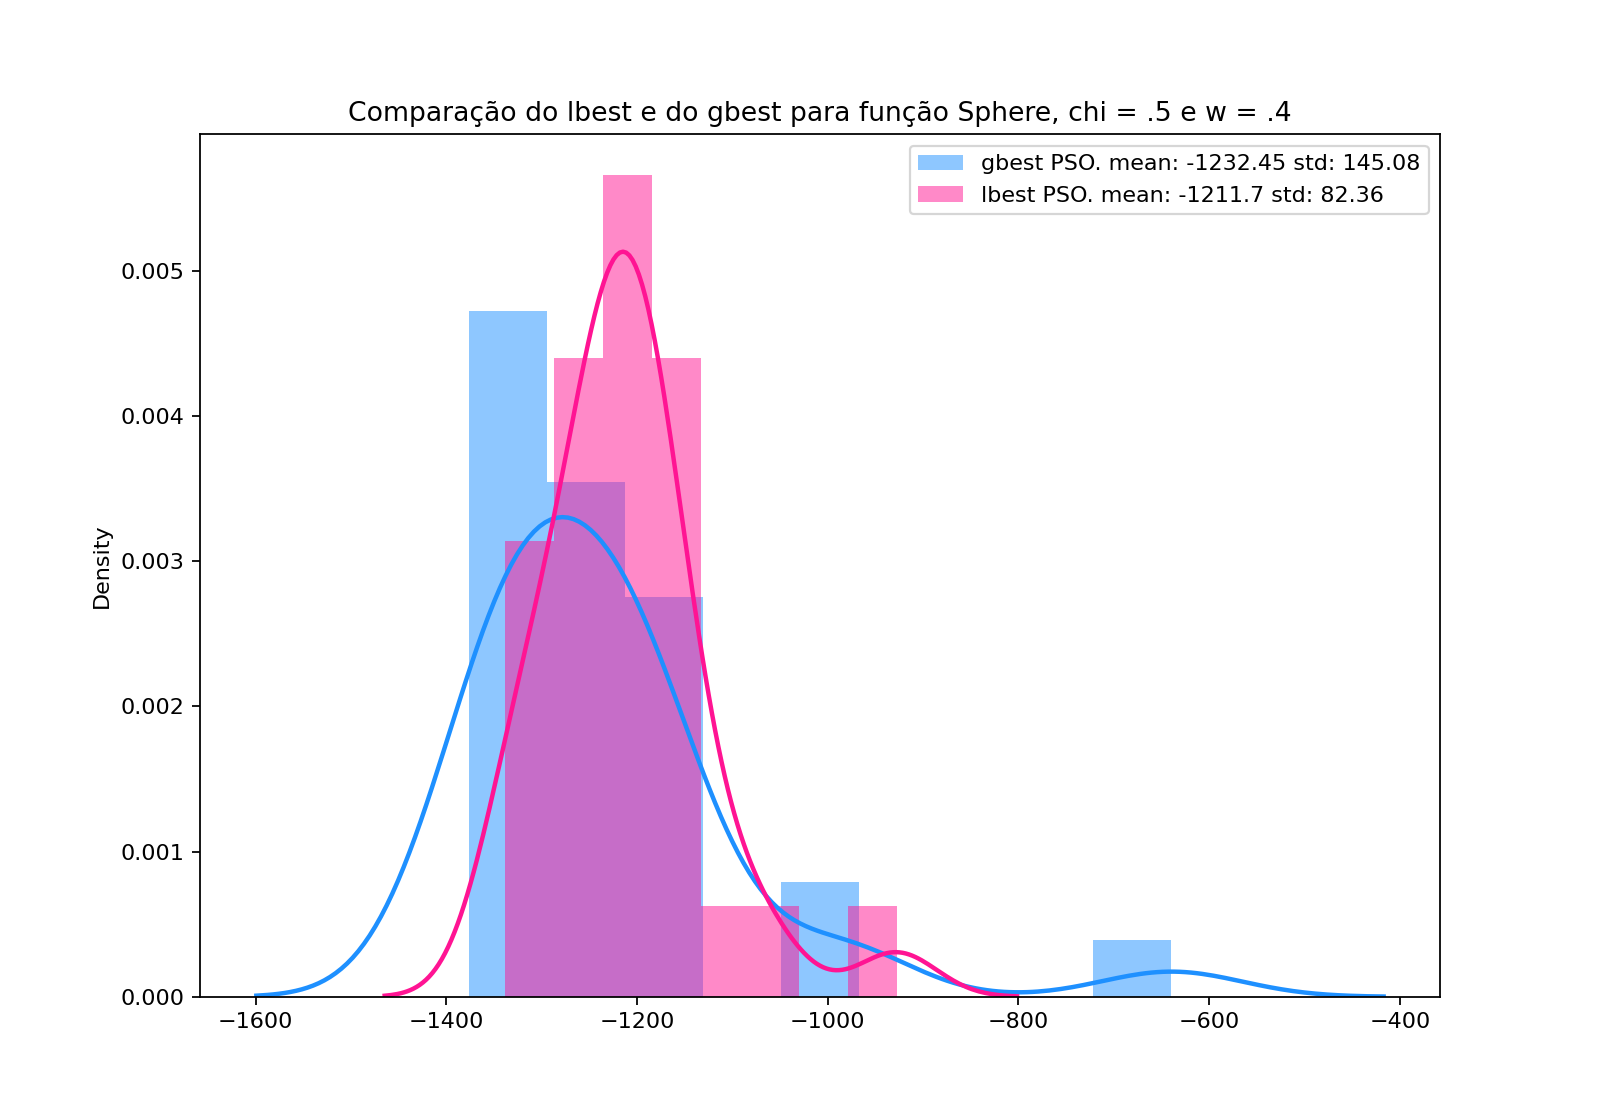

In [16]:
title = 'Comparação do lbest e do gbest para função Sphere, chi = 1 e w = 1'
pso_displot(s_gbestA1, s_lbestA1, title)

title = 'Comparação do lbest e do gbest para função Sphere, chi = 1 e w = .4'
pso_displot(s_gbestB1, s_lbestB1, title)

title = 'Comparação do lbest e do gbest para função Sphere, chi = .5 e w = 1'
pso_displot(s_gbestC1, s_lbestC1, title)

title = 'Comparação do lbest e do gbest para função Sphere, chi = .5 e w = .4'
pso_displot(s_gbestD1, s_lbestD1, title)

- **chi = 1 e w = 1:** Os dois termos com o valor 1 basicamente não interferem na execução do algoritmo. Então nesta configuração podemos observar o que acontece sem a influência destes parâmetros. Nestas condições, podemos observar que o gbest se comportou muito bem, atingindo uma média bem próxima de -1400 (ótimo conhecido) e um desvio padrão muito baixo. Já o lbest atingiu resultados muito variados, com uma média bem diferente do valor ótimo conhecido.

- **chi = 1 e w = 0.4:** Com a inclusão do baixo peso de inercia adicionado, podemos observar que houve uma piora na convergencia do gbest, que não conseguiu atingir a mesma média da execução anterior e teve um desvio padrão maior também. Já o lbest teve uma melhora considerável. Continua com valores de ótimo mais variados do que o gbest (o que faz sentido, uma vez que as velocidades são ajudas considerando apenas a vizinhança em anel), porem se aproximou mais do ponto ótimo conhecido de -1400.

- **chi = 0.5 e w = 1:** Ao tirarmos o coeficiente de inercia e adicionarmos o parâmetro de conscrição, é possivel observar que as duas médias pioraram em relação à execução anterior. Não é uma diferença estatisticamente relevante pois há um desvio padrão considerável. O gbest aparenta ter uma performance ligeiramente melhor também nesta disposição.

- **chi = 0.5 e w = 0.4:** Tendo tanto o parâmetro de conscrição quanto o peso de inercia é possivel notar um aumento na variedade de soluções ótimas e uma piora nas médias. O gbest continua apresentando performance ligeiramente melhor em comparação o lbest nesse cenário também 

Para a função **Sphere** a melhor execução foi o PSO gbest com chi = 1 e w = 1.

#### Rastrigin

<IPython.core.display.Javascript object>


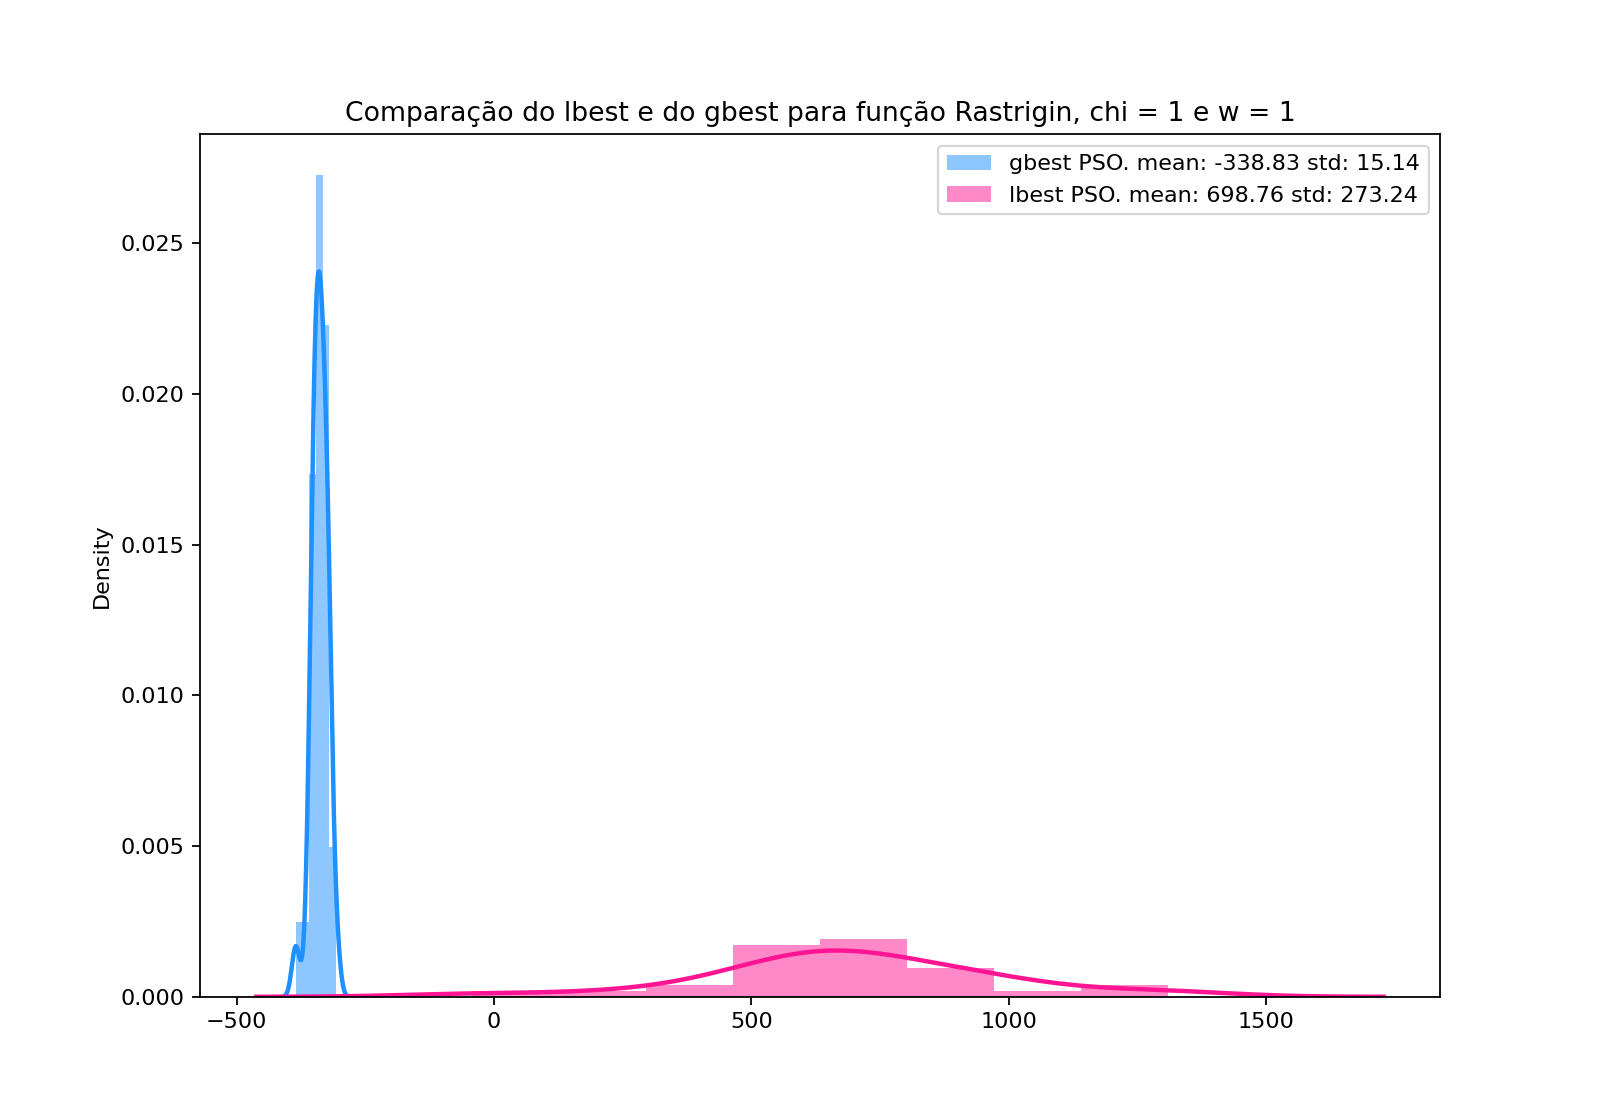

<IPython.core.display.Javascript object>


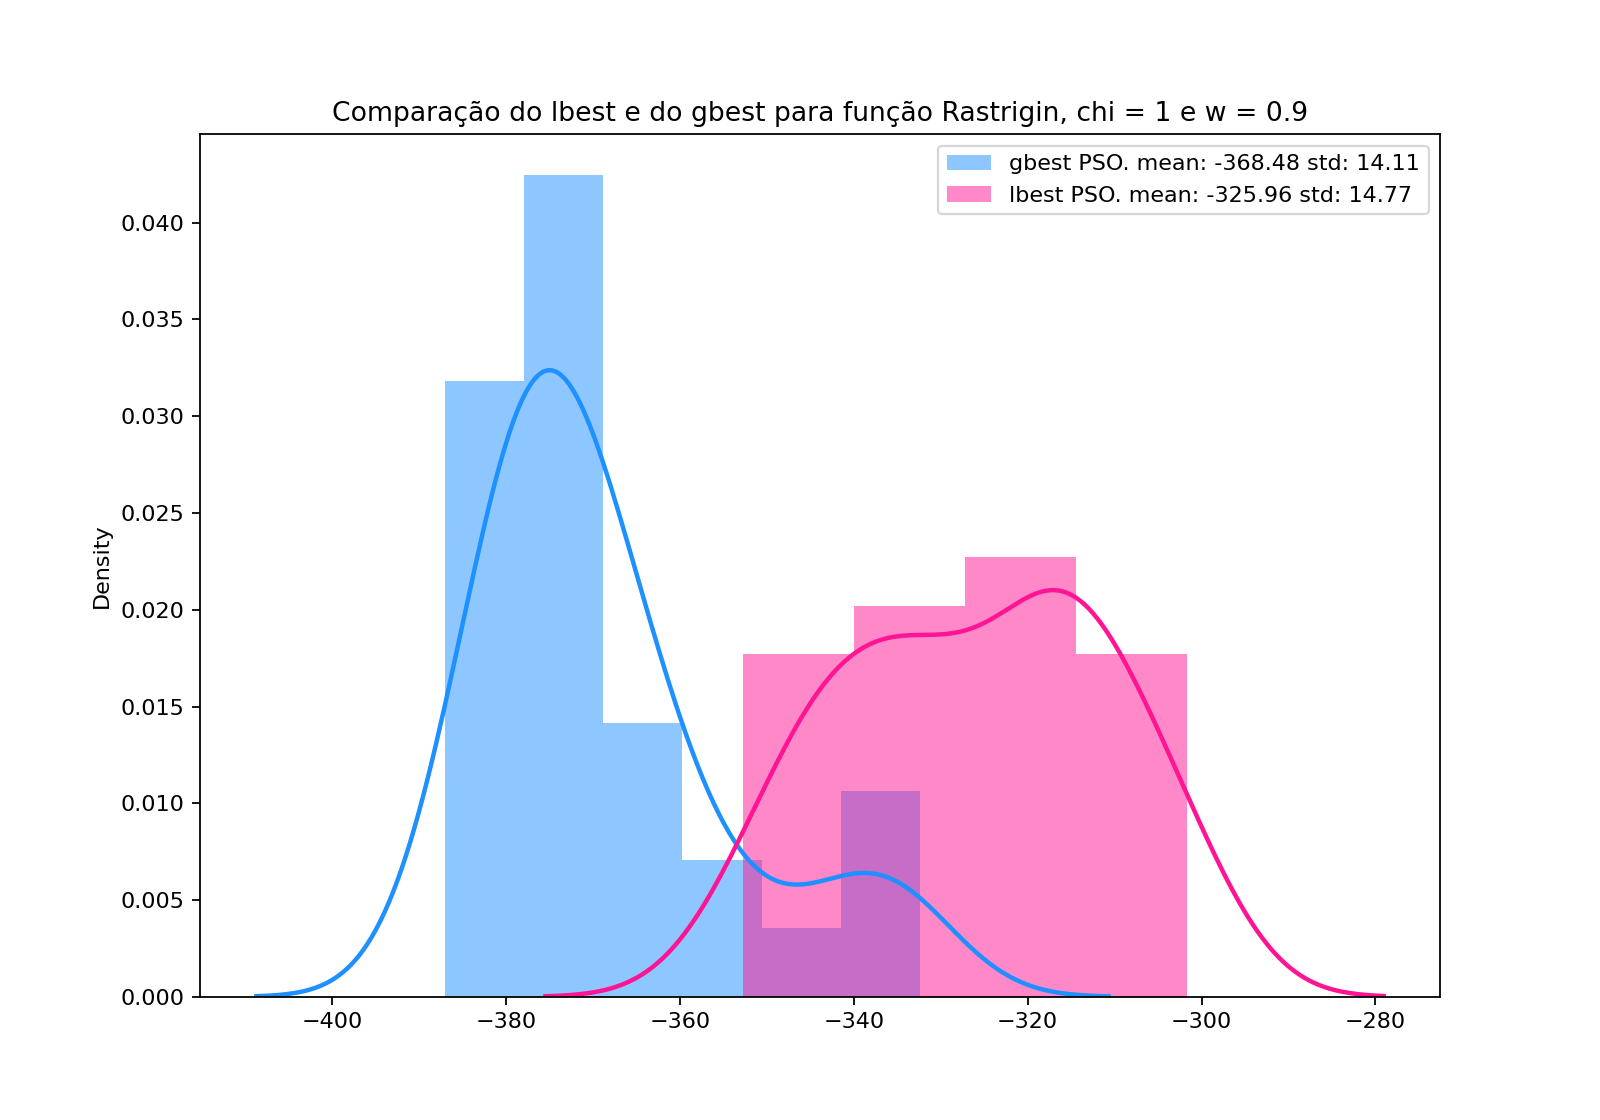

<IPython.core.display.Javascript object>


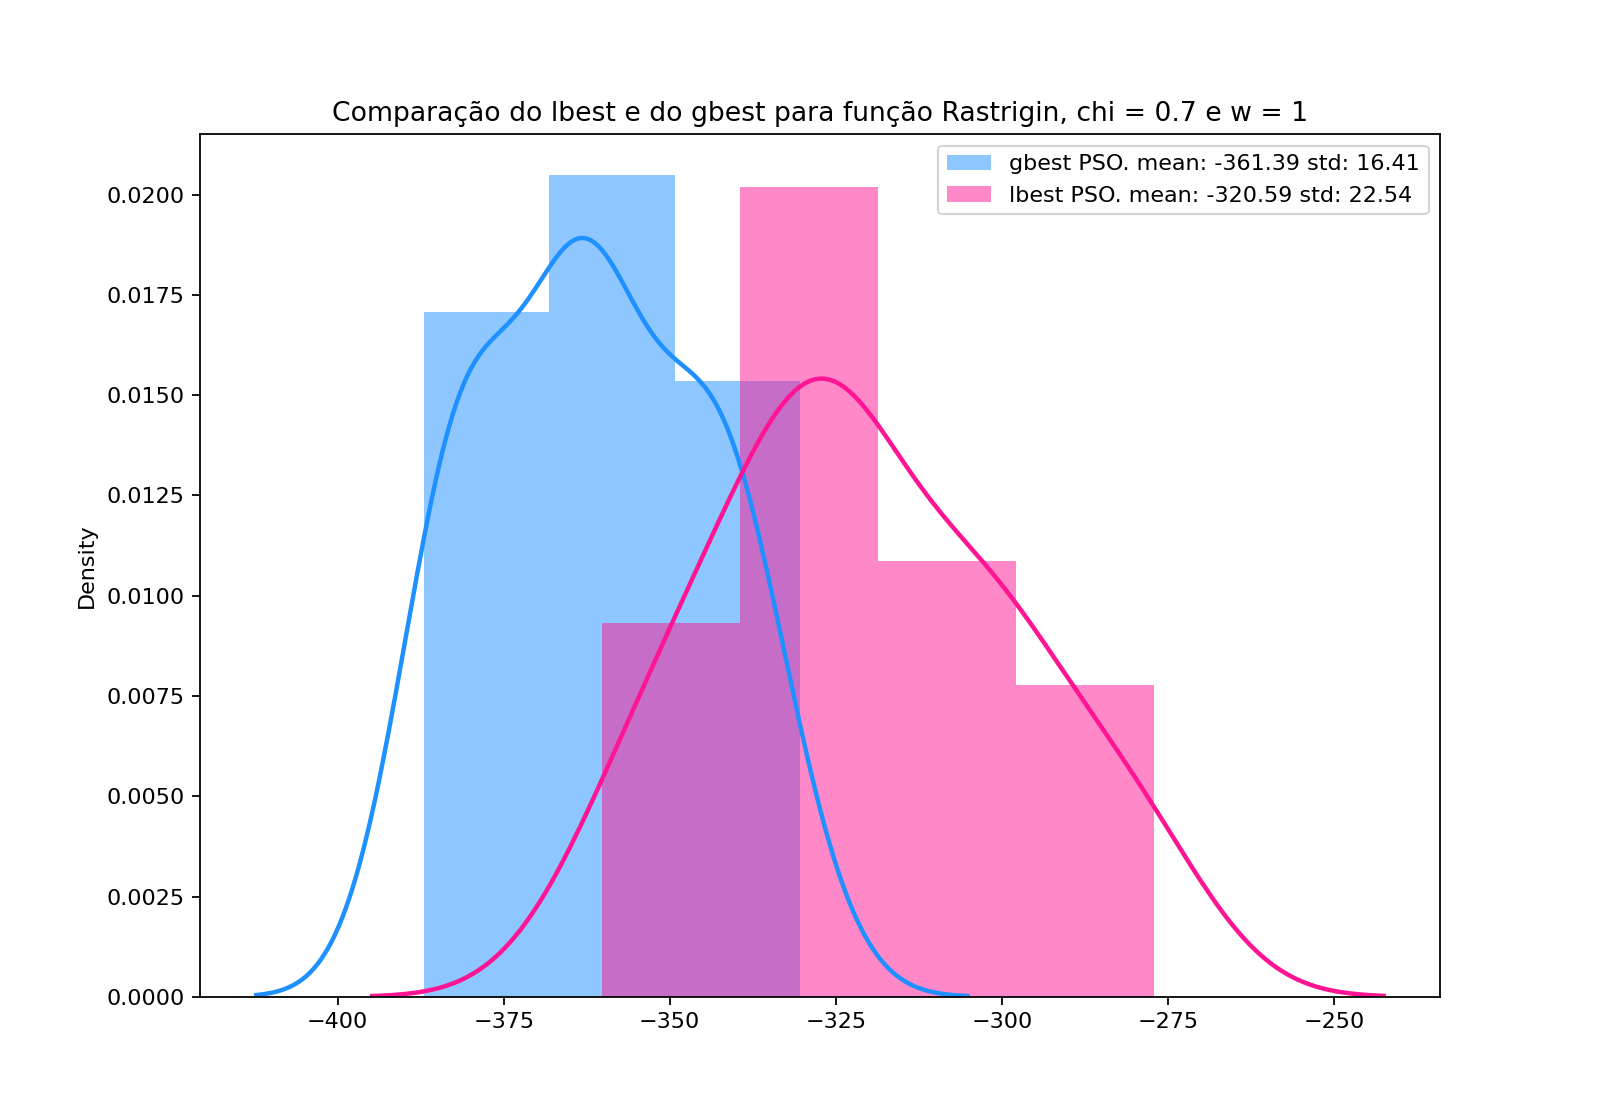

<IPython.core.display.Javascript object>


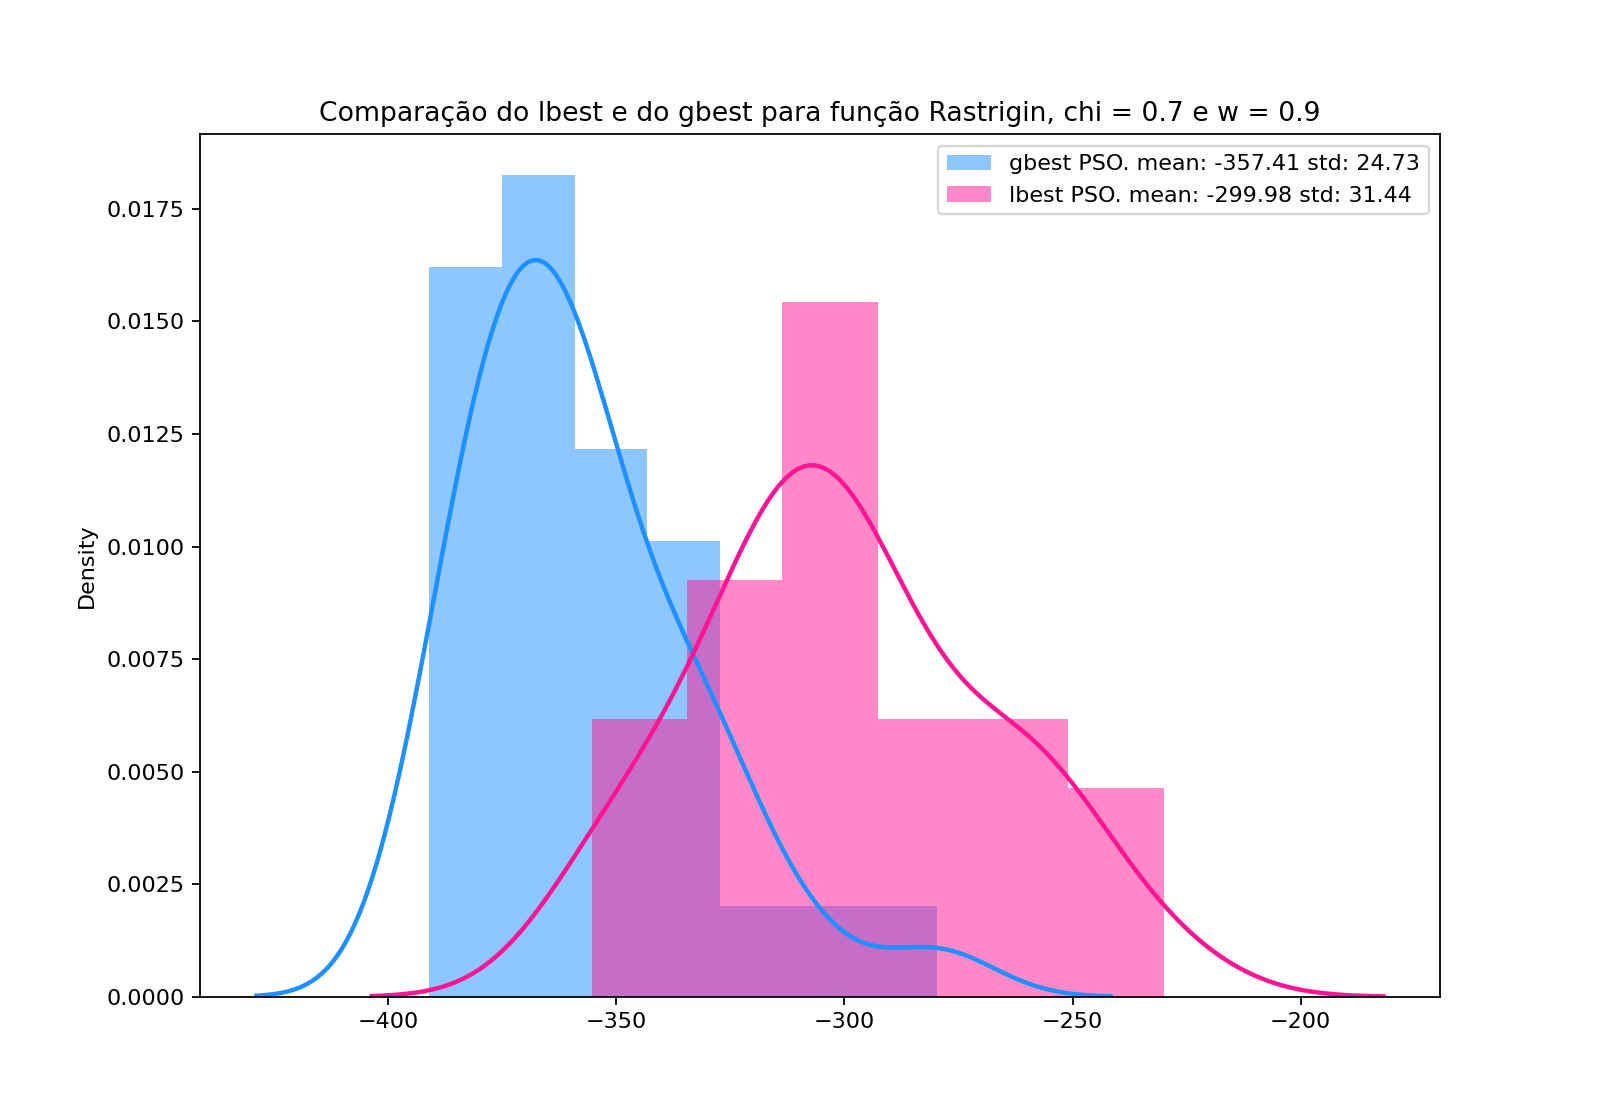

In [17]:
title = 'Comparação do lbest e do gbest para função Rastrigin, chi = 1 e w = 1'
pso_displot(s_gbestA2, s_lbestA2, title)

title = 'Comparação do lbest e do gbest para função Rastrigin, chi = 1 e w = 0.9'
pso_displot(s_gbestB2, s_lbestB2, title)

title = 'Comparação do lbest e do gbest para função Rastrigin, chi = 0.7 e w = 1'
pso_displot(s_gbestC2, s_lbestC2, title)

title = 'Comparação do lbest e do gbest para função Rastrigin, chi = 0.7 e w = 0.9'
pso_displot(s_gbestD2, s_lbestD2, title)

- **chi = 1 e w = 1:** Os dois termos com o valor 1 basicamente não interferem na execução do algoritmo. Então nesta execução podemos observar o que acontece sem a influência destes parâmetros. Nestas condições, podemos observar que o gbest teve um bom resultado, atingindo uma média próxima de -400 (ótimo conhecido) e um desvio padrão relativamente baixo. Já o lbest atingiu resultados muito variados, com uma média não tão próxima do valor ótimo conhecido, o que nos leva a entender que ele convergiu para diversos mínimos locais.

- **chi = 1 e w = 0.9:** Com o baixo peso de inercia adicionado, podemos observar que tanto o lbest quanto o gbest ficaram proximos do ponto ótimo conhecido de -400. O lbest apresentou um desvio padrão inferior ao gbest, o que indica que a adição do coeficiente de inercia contribuiu para melhoria do algoritmo.

- **chi = 0.7 e w = 1:** Ao tirarmos o coeficiente de inercia e adicionarmos o parâmetro de conscrição, é possivel observar que o gbest teve um comportamento estatisticamente semelhante ao comportamento da ultima execução. Já o lbest apresentou uma piora estatisticamente significante

- **chi = 0.7 e w = 0.9:** Tendo tanto o parâmetro de conscrição quanto o peso de inercia, o gbest apresentou os mesmos resultados das ultimas execuções, com ótimo proximo a -400. Já o lbest ficou pior em comparação com a ultima execução e começou a se distanciar do ótimo global.

Para a função **Rastrigin** a melhor execução foi o PSO gbest com chi = 0.1 e w = 1, porém as outras execuçòes do gbest tiveram resultados próximos.

## Conclusão

Como foi possivel observar durante a implementacão deste trabalho, a os parâmetros do PSO tendem a influenciar bastante a execução do algoritmo, podendo privilegiar tanto covergencias globais quanto convergencias locais. É necessário portanto ter um entendimento completo do problema e do tipo de função que será otimizada, para que os parâmetros sejam corretamente estipulados e a execução do algoritmo atinja os resultados esperados. Para as duas funções objetivo analisadas, o global best PSO apresentou uma precisão superior.